# 0. Installing embedding prerequisites

If you use x86 machines or ARM (Mac M1/M2/...) chips with python 3.8, then you may benefit from `spacy` embedding.

In [1]:
!pip install --upgrade spacy
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 4.9 MB/s eta 0:00:00
  Attempting uninstall: spacy
    Found existing installation: spacy 3.6.1
    Uninstalling spacy-3.6.1:
      Successfully uninstalled spacy-3.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-web-sm 3.6.0 requires spacy<3.7.0,>=3.6.0, but you have spacy 3.7.1 which is incompatible.
2023-10-16 06:50:39.513333: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 06:50:40.771350:

Check that is works:

In [2]:
import spacy
nlp = spacy.load('en_core_web_md')

def embed(text: str):
    return nlp(line['Question']).vector

## 0.a. ARM case

Probably by the day of your lab the issue is not fixed. Then use `fasttext` of whatever.

# 00. Index data structure

And now let us install the NMSlib. To avoid M1 crashes please do not use prebuilt wheels.

In [3]:
!pip uninstall nmslib -y
!pip install nmslib --no-binary :all:

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.6/171.6 kB 16.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for nmslib: filename=nmslib-2.1.1-cp310-cp310-linux_x86_64.whl size=13578641 sha256=ae2eb2138bd70ffe250d9c2962168cb1fdfee567204d52d330dddeb2991c04ee
  Stored in directory: /root/.cache/pip/wheels/21/1a/5d/4cc754a5b1a88405cad184b76f823897a63a8d19afcd4b9314
  Created wheel for pybind11: filename=pybind11-2.6.1-py2.py3-none-any.whl size=188520 sha256=0b8d5045b2cb6e1ae5a17263471b382d31e1071b4cc6f3fe12952d9fc344501c
  Stored in directory: /root/.cache/pip/wheels/05/6d/14/25d7698ea031d63f083802c87c7ef546bc2f735631f1daf8a8
Successfully built nmslib pybind11


Check it works:

In [4]:
import nmslib

# Generate some vectors

Download [Jeopardy dataset](https://github.com/hsu-ai-course/hsu.ai/blob/master/code/datasets/nlp/JEOPARDY_CSV.zip). Unpack it! Read it as CSV. Embed `Question`s with spacy model.

In [7]:
MAX = 30000
DATASET_FILENAME = '/content/JEOPARDY_CSV.csv'

In [8]:
import csv
import numpy as np

strings = []

with open(DATASET_FILENAME, 'r', encoding='utf8') as f:
    dr = csv.DictReader(f, delimiter=',')
    for i, line in enumerate(dr):
        if i == MAX: break
        strings.append(line)

print("Strings:", len(strings))

Strings: 30000


In [9]:
import tqdm
import pickle
import os

# if vector dimension is different - please change
vectors = np.zeros((MAX, 300))

if os.path.exists('vectors'):
    print("Vectors are precomputed! Loading ...", end='')
    with open('vectors', 'rb') as f:
        vectors = pickle.load(f)
    print(" done")
else:
    print("Vectors are not precomputed. Computing ...", end='')
    for i, line in enumerate(tqdm.tqdm(strings)):


        # TODO your code here to find `Question` embedding and write it to i'th string of the matrix
        vectors[i, :] = ...



    print(" dumping ...", end='')
    with open('vectors', 'wb') as f:
        pickle.dump(vectors, f)
    print(" done")

Vectors are not precomputed. Computing ...

100%|██████████| 30000/30000 [04:58<00:00, 100.47it/s]


 dumping ... done


In [10]:
print("Vectors:", vectors.shape, "| strings:", len(strings))

Vectors: (30000, 300) | strings: 30000


# 1. Index construction

- index methods: `'nsw'`, `'hnsw'` and [others](https://github.com/nmslib/nmslib/blob/master/manual/methods.md). We will use `hnsw` and `brute_force`.
- space: `'cosinesimil'` and [many others](https://github.com/nmslib/nmslib/blob/master/manual/spaces.md). We will use `cosinesimil`.
- `post` parameters of `createIndex()`: optimization after HNSW built. [Read more here](https://github.com/nmslib/nmslib/blob/master/manual/methods.md#graph-based-search-methods-sw-graph-and-hnsw).
- `ef`: the size of the dynamic list for the nearest neighbors (used during the search). `efConstruction` improves the quality of a constructed graph and leads to higher accuracy of search, also leads to longer indexing times. Typically `ef=100..2000`. Similarly, increasing the value of `efSearch` improves recall at the expense of longer retrieval time.
- `M`: defines the maximum number of neighbors. The reasonable range of values for these parameters is `5..100`.

Here implement `find_for_vector` and `find_for_batch` methods according to the quick start documentation.

In [12]:
import nmslib

def get_index(
        vectors,
        method='hnsw',
        space='cosinesimil',
        postprocessing_optimization_level=2,
        efConstruction=100,
        efSearch=100,
        M=16,
        cutoff=None
):
    import gc
    gc.collect()

    if cutoff is not None:
        vectors = vectors[:cutoff]

    index = nmslib.init(method=method, space=space, space_params = {
        "efConstruction": efConstruction,
        "efSearch": efSearch,
        "M": M,
    })
    index.addDataPointBatch(vectors)
    if method == 'hnsw':
        # this parameter appies to HNSW only
        index.createIndex({'post': postprocessing_optimization_level}, print_progress=True)
    else:
        index.createIndex(print_progress=True)
    return index



# should return the list of ids, sorted by dist from closest
def find_for_vector(index, vector, nn) -> list:
    # TODO your code here
    ...


# should return list of lists of indices. Outer list is len(batch), inner lists are `nn`
def find_for_batch(index, batch, nn) -> list:
    # TODO your code here
    ...

## Construct buckets with ground truth

In [13]:
bucket = ['opera', 'math', 'geography', 'films', 'cats', 'zebra',
          'cooking', 'armory', 'war', 'history', 'money', 'books',
          'quantum physics', 'snakes', 'sea', 'plants', 'chemistry',
          'stars', 'science fiction', 'languages', 'clothes']
bucket_vectors = [embed(t) for t in bucket]
bucket += [s['Question'] for s in strings[150:14000:7]]
bucket_vectors += [v for v in vectors[150:14000:7]]
print(len(bucket))

2000


## Let's collect ACCURATE nearest neighbours with flat index (no index)

In [14]:
# dataset sizes
DS = [2000, 5000, 10000, 20000, 30000]
# M values
MS = [8, 16, 32, 64]
# ef values
EFS = [100, 200, 400]

In [15]:
flats = {}
for cutoff in DS:
    flats[cutoff] = get_index(vectors, method='brute_force', cutoff=cutoff)

In [31]:
ground_truth = {}
for cutoff in DS:
    bucket_results = find_for_batch(flats[cutoff], bucket_vectors, nn=1000)
    print(bucket_results[0])
    ground_truth[cutoff] = bucket_results

[1031, 288, 1112, 193, 855, 1073, 1408, 634, 595, 603, 803, 1144, 811, 282, 1784, 1642, 214, 1193, 1063, 1255, 1105, 1050, 1005, 1401, 1718, 1777, 1842, 24, 1603, 842, 1386, 1141, 751, 1697, 361, 1303, 989, 262, 1665, 1852, 1086, 1392, 434, 445, 1425, 1695, 1271, 750, 883, 1263, 1771, 1500, 771, 1843, 1929, 1715, 481, 1907, 1446, 919, 250, 1282, 1808, 1189, 931, 654, 390, 563, 799, 647, 1113, 1382, 816, 1535, 1304, 1434, 814, 959, 346, 793, 84, 244, 1712, 613, 123, 1506, 1046, 573, 936, 1244, 1081, 1868, 1150, 528, 499, 408, 928, 1513, 294, 1228, 600, 539, 1231, 1970, 1429, 738, 26, 135, 1452, 1147, 557, 94, 712, 1928, 815, 1559, 1420, 673, 1935, 1692, 655, 339, 984, 960, 545, 345, 1110, 1939, 684, 791, 1974, 240, 1488, 141, 3, 966, 1285, 1317, 892, 1089, 1167, 1730, 127, 1512, 835, 231, 1489, 714, 808, 1280, 832, 1896, 1957, 860, 1919, 916, 921, 1291, 837, 179, 201, 705, 1175, 614, 1656, 601, 579, 1720, 930, 1030, 411, 241, 1599, 136, 1900, 619, 57, 1439, 1647, 1783, 1706, 414, 139, 9

## Compute recall @N

Implement recall@N computation. Discuss the values.

In [17]:
def recall(sorted_result : list, sorted_ground_truth: list, N: int) -> float:
    # your code here
    ...

In [18]:
for b in ground_truth[10000][:5]:
    print(recall(b, b, 700), recall(b[:500], b, 700), recall(b[:350], b, 700), recall([], b, 700))

1.0 0.7142857142857143 0.5 0.0
1.0 0.7142857142857143 0.5 0.0
1.0 0.7142857142857143 0.5 0.0
1.0 0.7142857142857143 0.5 0.0
1.0 0.7142857142857143 0.5 0.0


Discuss the values.
- Why do you see these numbers?
- Why are they equal?

# 2. Test HNSW

Create an index with default settings and assess its recall numbers.

In [19]:
hnsw = get_index(vectors, method='hnsw')

In [23]:
vector_id = 5
vector = bucket_vectors[vector_id]
reference = ground_truth[DS[-1]][vector_id]

for n in [100, 1000, 2000]:
    ids = find_for_vector(hnsw, vector, nn=n)
    print(f"recall@{n} =", recall(ids, reference, n))

recall@100 = 0.86
recall@1000 = 0.356
recall@2000 = 0.178


Discuss: why recall drops with the growth of N?

# 3. Assessment

Let's vary parameters of index to see how it influences the following properties:
- construction time.
- search time (for a bucket in total).
- `recall@100`, `recall@1000`, and `recall@100` for 1000 results.

What do we vary? Dataset size `D`, `M`, and `ef`.

In [24]:
import time

def test(index, bucket_vectors, nn=100):
    start = time.time()
    result = find_for_batch(index, bucket_vectors, nn=nn)
    return time.time() - start, result

In [26]:
from itertools import product
import tqdm
import time

# full combination of parameters for grid search
hypers = list(product(MS, DS, EFS))
result = []

for M, D, ef in tqdm.tqdm(hypers):
    start = time.time()

    # todo write here the code to construct index object given provided hyperparameters
    I = get_index(
        vectors,
        method='hnsw',
        efConstruction=ef,
        efSearch=ef,
        M=M,
        cutoff=D
    )

    build_time = time.time() - start

    t100, ids100 = test(I, bucket_vectors, nn=100)
    t1000, ids1000 = test(I, bucket_vectors, nn=1000)
    r100, r1000, r100_ = 0., 0., 0.

    for i, r in enumerate(ground_truth[D]):
        r100 += recall(ids100[i], r, 100)
        r1000 += recall(ids1000[i], r, 1000)
        r100_ += recall(ids1000[i], r, 100)

    r100 /= len(bucket_results)
    r1000 /= len(bucket_results)
    r100_ /= len(bucket_results)

    result.append(
        [M, D, ef, build_time, t100, t1000, r100, r1000, r100_]
    )

100%|██████████| 60/60 [13:26<00:00, 13.44s/it]


In [33]:
import pandas as pd
headers = ["M", "D", "ef", "build time", "search time 100",
           "search time 1000", "recall@100", "recall@1000", "recall@100*"]
d = {}
for i, h in enumerate(headers):
    d[headers[i]] = [r[i] for r in result]

df = pd.DataFrame(d)
# df.to_pickle('results.pkl')
df

,M,D,ef,build time,search time 100,search time 1000,recall@100,recall@1000,recall@100*
0,8,2000,100,1.176417,0.109136,0.252289,0.902275,0.269909,0.902275
1,8,2000,200,1.716906,0.169679,0.307026,0.901750,0.268308,0.901750
2,8,2000,400,1.434685,0.101215,0.184626,0.901335,0.269437,0.901335
3,8,5000,100,2.960652,0.111673,0.210579,0.880055,0.298484,0.880055
4,8,5000,200,2.949077,0.119969,0.205418,0.879980,0.297103,0.879980
5,8,5000,400,3.796022,0.216253,0.386631,0.880100,0.298833,0.880100
6,8,10000,100,6.937208,0.139838,0.235250,0.864095,0.304848,0.864095
7,8,10000,200,8.438271,0.134577,0.302595,0.864135,0.304812,0.864135
8,8,10000,400,6.571238,0.125077,0.248595,0.864215,0.305453,0.864215
9,8,20000,100,20.459228,0.232986,0.415606,0.849525,0.307075,0.849525


Discuss, how parameters (using the table) affect perfromance?

### * Load results (if needed)

(NB: for some reason `pyplot` does not survive together with `nmslib` in Windows. So you may save we save and load).

In [32]:
import pandas as pd
headers = ["M", "D", "ef", "build time", "search time 100", "search time 1000", "recall@100", "recall@1000", "recall@100*"]
DS = [2000, 5000, 10000, 20000, 30000]
# M values
MS = [8, 16, 32, 64]
# ef values
EFS = [100, 200, 400]
# df = pd.read_pickle('results.pkl')

## Displaying results

Let us display them now!

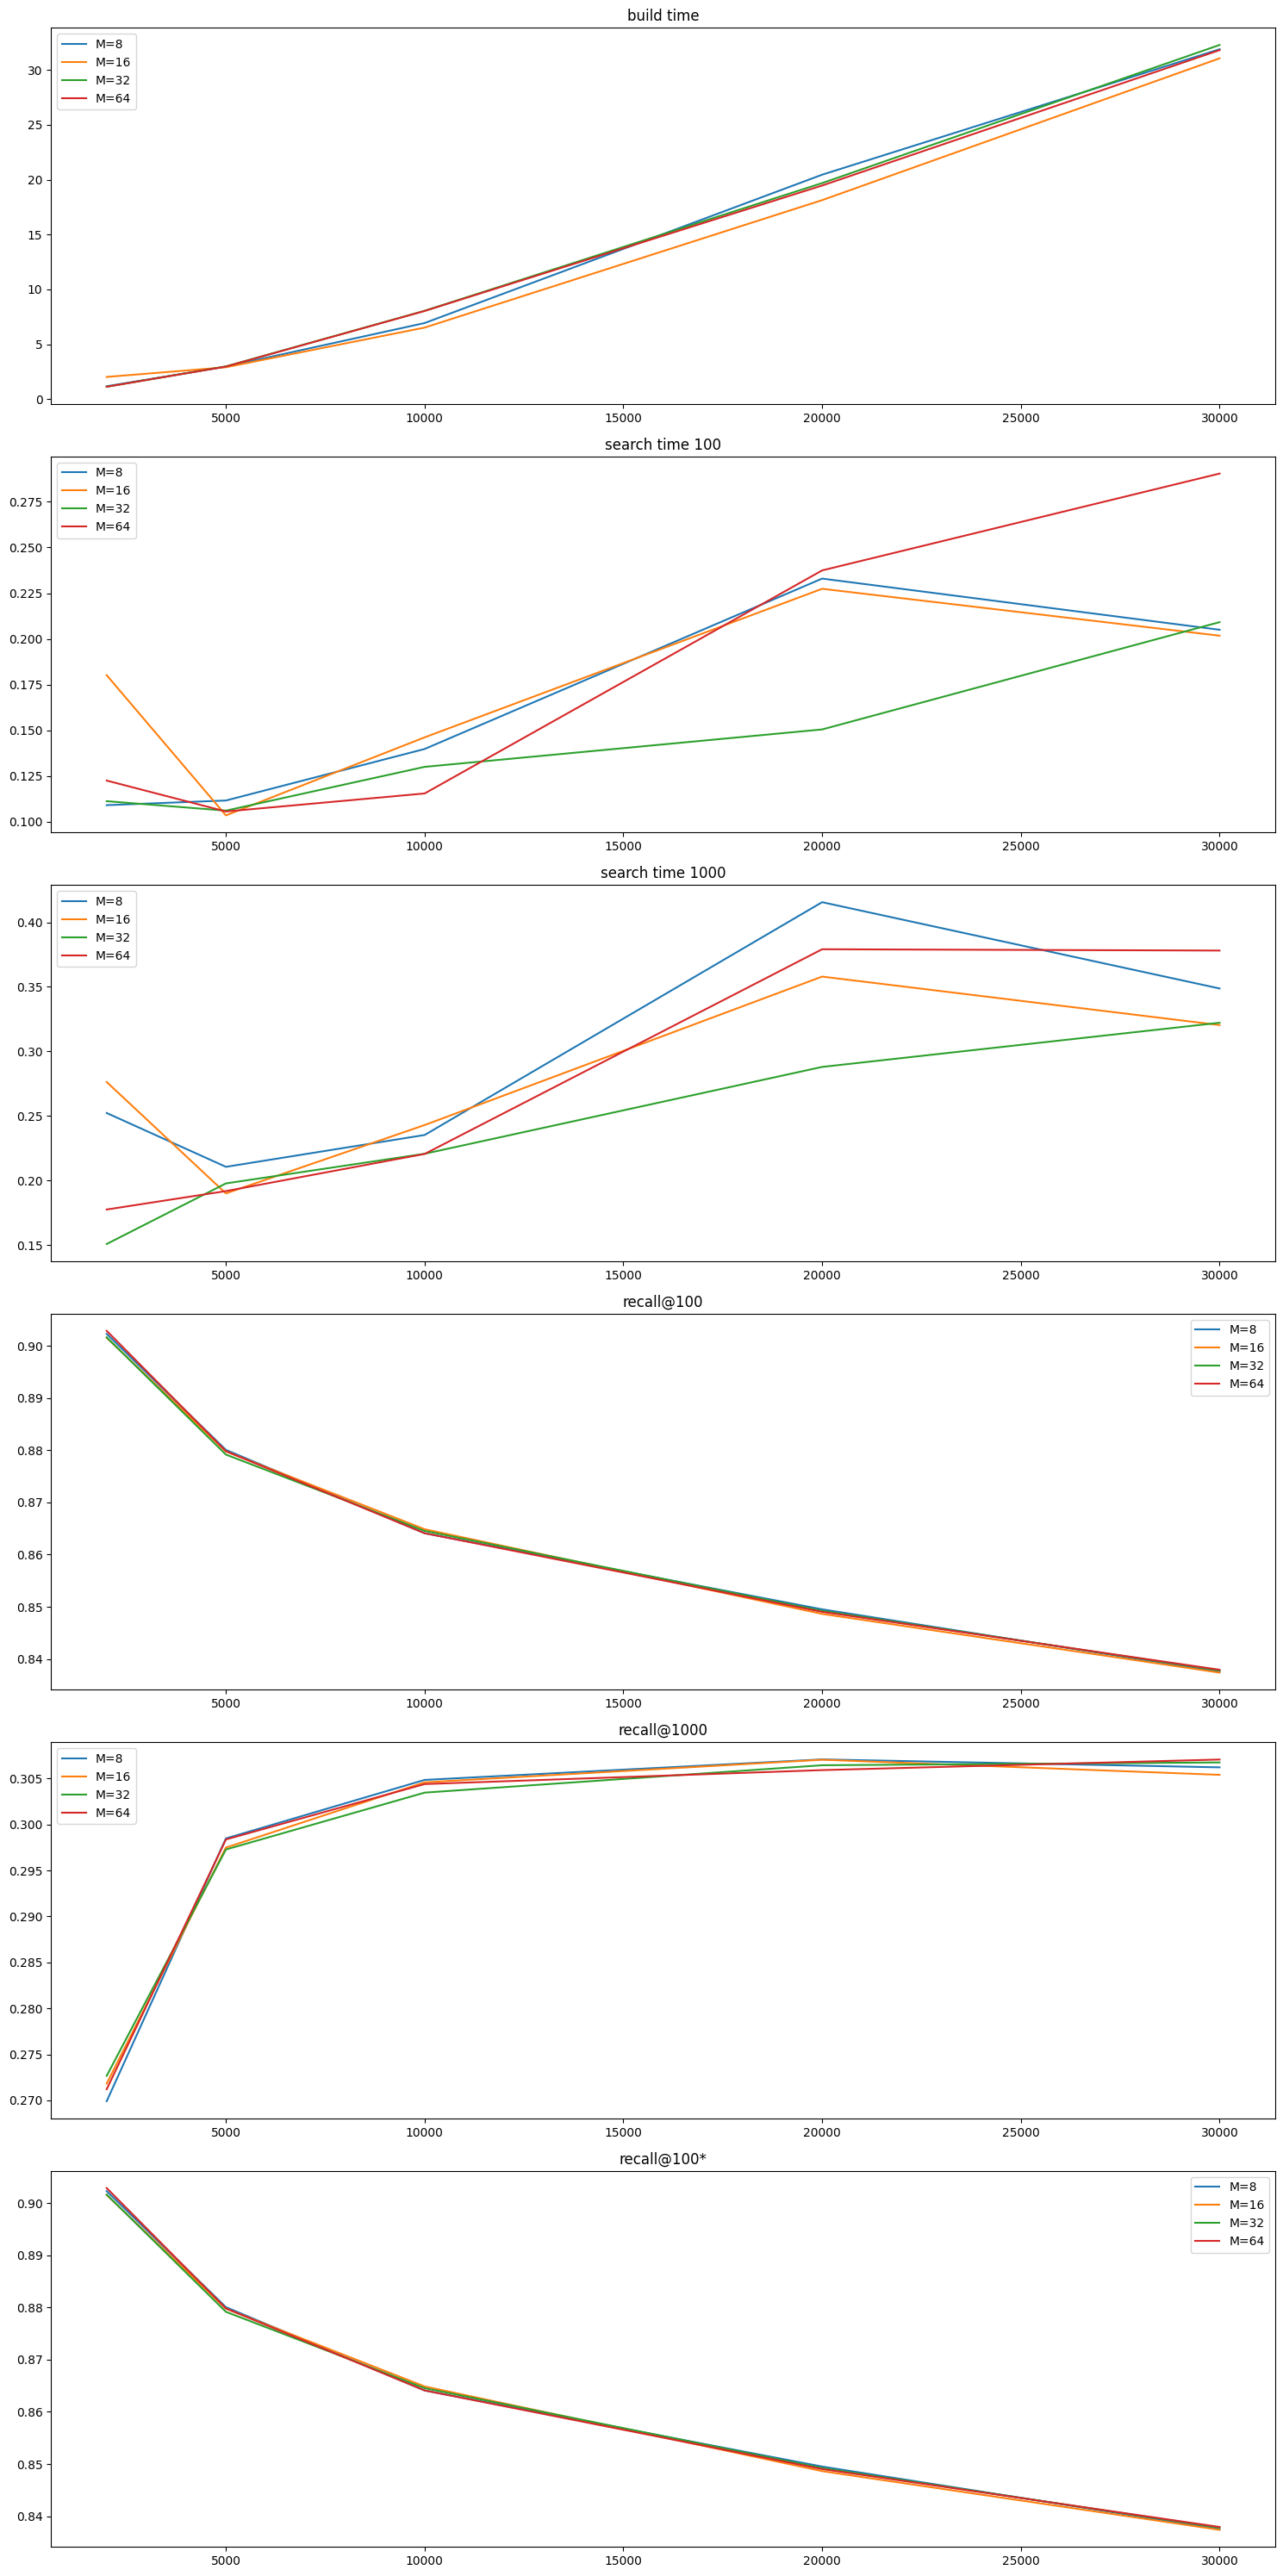

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(len(headers) - 3, figsize=(15, 30))

for j in range(len(MS)):
    for k in range(3, len(headers)):
        # print(MS[j], k)
        subdata = df[(df['M'] == MS[j]) & (df['ef'] == EFS[0])]
        ax[k-3].plot(subdata['D'], subdata[headers[k]], label=f"M={MS[j]}")
        ax[k-3].set_title(f"{headers[k]}")
        ax[k-3].legend()

plt.tight_layout()
plt.show()